In [1]:
# load bluesky data
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("withalim/bluesky-posts")
bsky_posts = [split.to_pandas() for split in dataset.values()] # collect all datasets

bsky_posts = pd.concat(bsky_posts ,ignore_index=True)
bsky_posts = bsky_posts[['text']]
print(bsky_posts.shape)
bsky_posts.head()

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

(7877660, 1)


,text
0,yo
1,:(
2,test
3,I posted this 100 years ago!
4,Nope


In [2]:
from langdetect import detect, LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'
    
bsky_posts_sample = bsky_posts.sample(100000)

bsky_posts_sample['language'] = bsky_posts_sample['text'].apply(detect_language)

In [3]:
import langcodes

def get_full_language_name(lang_code):
    if lang_code == 'unknown':
        return 'Unknown'
    return langcodes.Language.get(lang_code).display_name()


bsky_posts_sample['language'] = bsky_posts_sample['language'].apply(get_full_language_name)


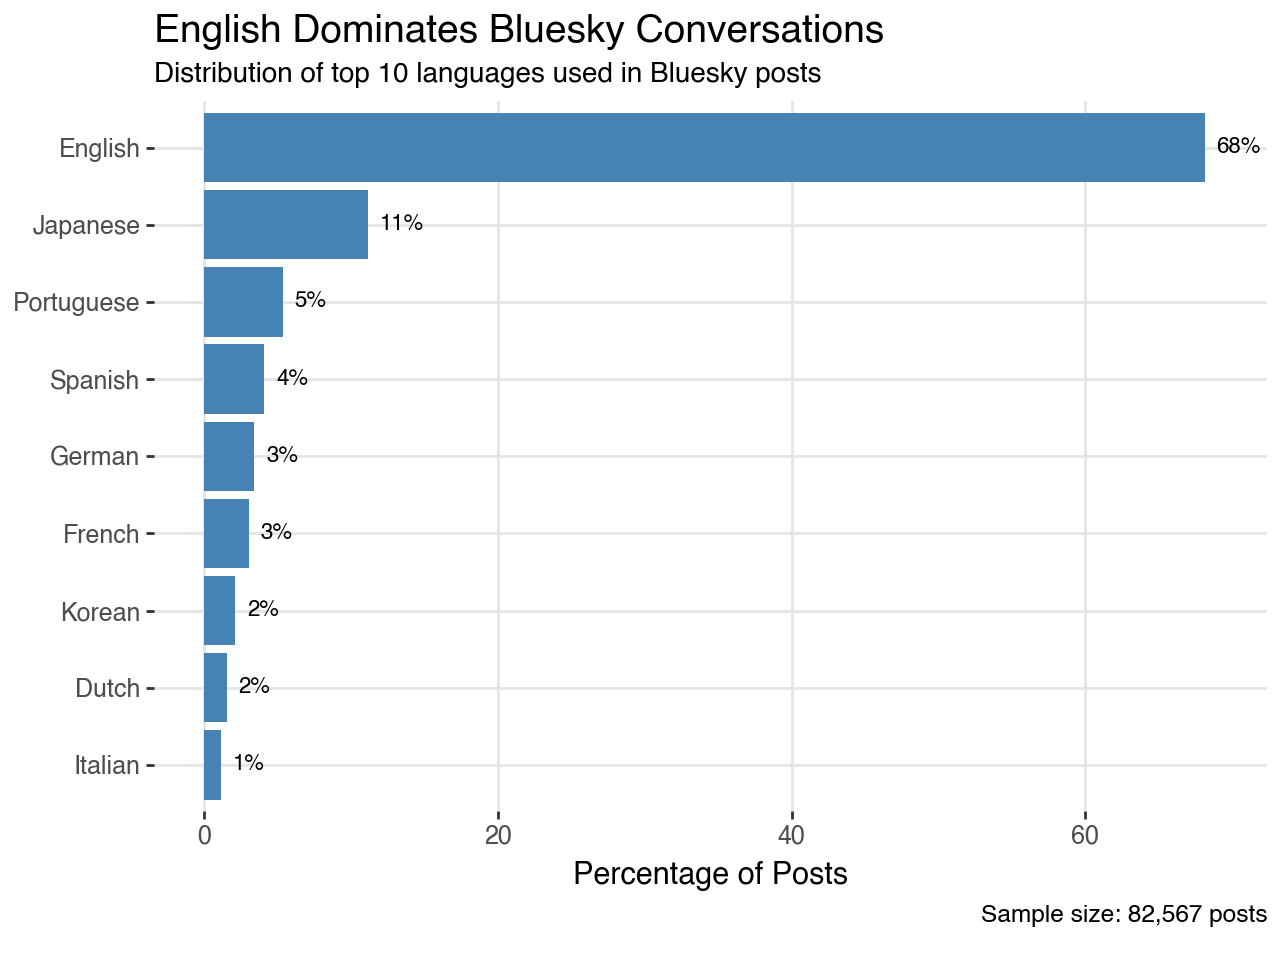

In [11]:
from plotnine import * 

top_languages = bsky_posts_sample['language'].value_counts().nlargest(10).reset_index()
top_languages.columns = ['Language', 'Count']
top_languages = top_languages[top_languages['Language'] != 'Unknown']

# Format count values
top_languages['Count_formatted'] = top_languages['Count'].apply(lambda x: f"{x:,}")
top_languages['Percentage'] = top_languages['Count'] / top_languages['Count'].sum() * 100
top_languages['Label'] = top_languages.apply(lambda x: f"{round(x['Percentage']):.0f}%", axis=1)

blue_palette = '#4682B4'  # Steel blue

plot = (
    ggplot(top_languages, aes(x='reorder(Language, Percentage)')) +
    geom_bar(aes(weight='Percentage'), fill=blue_palette) +
    geom_text(aes(y='Percentage', label='Label'), nudge_y=.8, ha='left', size=8) +
    labs(
        title='English Dominates Bluesky Conversations',
        subtitle='Distribution of top 10 languages used in Bluesky posts',
        x='',  
        y='Percentage of Posts',
        caption= f'Sample size: {top_languages["Count"].sum():,} posts\n'
    ) +
    coord_flip() +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold"),
        plot_subtitle=element_text(size=10),
        axis_text=element_text(size=9),
        panel_grid_minor=element_blank(),
        panel_border=element_blank()
    )
)

plot